Loading intrinsic population
Loading GW population

EoS: SFHo
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Zero

COUNTERPART SEARCH (GW subthreshold)
Computing GW limiting thresholds


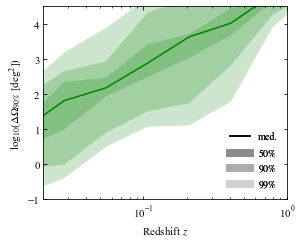

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from matplotlib.lines import Line2D
import corner
import sys
import warnings
warnings.filterwarnings("ignore")

from functions_ET import *
sys.path.insert(0, '../COMPAS')
from spin_class import *

# --- Plot style ---
plt.rcParams['font.family'] = "Times New Roman"
plt.rcParams['figure.figsize'] = (4.3, 3.5)
plt.rcParams['figure.autolayout'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams["axes.axisbelow"] = False

# --- Load population ---
num = 1000000
eos = "SFHo"
mns_max = 2.058838

table = h5py.File(f'../horizons2/population/computed_population/bhns_{num}_{eos}_z10_mass_spin_thv_GWFAST_ET.hdf5', 'r')

DCOtype = 'BHNS'
poptype = 'A'
path = f'../horizons2/importance_sampling/mass_rate/ET_COMPASCompactOutput_{DCOtype}_{poptype}.h5'

distribution = 'NOT fixed'
spin_prescription = 'Zero'

if poptype == 'A':
    w_type, r0 = 'w_000', 94
    w_type_high, r0_high = 'w_000', 203
    w_type_low, r0_low = 'w_000', 30
elif poptype == 'B':
    w_type, r0 = 'w_000', 20
    w_type_high, r0_high = 'w_000', 100
    w_type_low, r0_low = 'w_312', 10

print("Loading intrinsic population")
mbh = table['mbh'][()]
mns = table['mns'][()]
lamb_ns = table['lamb_ns'][()]
spin_bh = table['spin_bh'][()]
z = table['z'][()]
dL = table['dL'][()]
thv = table['thv'][()]
ra = table['ra'][()]
dec = table['dec'][()]
m_dyn = table['m_dyn'][()]
v_dyn = table['v_dyn'][()]
m_disk = table['m_disk'][()]
m_out = table['m_out'][()]
final_x = table['final_x'][()]
E_bkt = table['E_bkt'][()]
E_k_jet = table['E_k_jet'][()]
Ec = table['Ec'][()]

print("Loading GW population")
snr_ETT = table['snr_ETT'][()]
sky_loc_ETT = table['sky_loc_ETT'][()]
table.close()

# --- Weights ---
np.random.seed(0)
spin = calculate_spin_olderCOMPASdata(data_path=path)

if spin_prescription == 'Bavera21':
    spinM1, spinM2 = spin.Bavera21()
elif spin_prescription == 'Qin21':
    spinM1, spinM2 = spin.Qin21()
elif spin_prescription == 'Uniform':
    spinM1, spinM2 = spin.Bavera21()
    spinM1 = np.random.uniform(0., 0.5, spinM1.shape)
    spinM2 = np.random.uniform(0., 0.5, spinM2.shape)
elif spin_prescription == 'Zero':
    spinM1, spinM2 = spin.Bavera21()
    spinM1 = np.zeros_like(spinM1)
    spinM2 = np.zeros_like(spinM2)

bhx = [2.5, 27]
nsx = [1.1, 3]
spinx = [0., 1.]
binsx = binsy = binsz = 50

if distribution == 'NOT fixed':
    table_w = h5py.File(f'../horizons2/population/computed_population/weight/w_bhns_{eos}_{spin_prescription}_notfixed.hdf5', 'r')
    C_mc = table_w['C_mc'][()]
    C_mc_low = table_w['C_mc_low'][()]
    C_mc_high = table_w['C_mc_high'][()]
    w = table_w['w'][()]
    w_low = table_w['w_low'][()]
    w_high = table_w['w_high'][()]
    table_w.close()

# --- Info print ---
print("")
print("EoS:", eos)
print("Population model:", poptype)
print("The mass and spin distributions are", distribution)
print("The spin prescription is:", spin_prescription)
print("")

# --- Limiting Thresholds ---
print("COUNTERPART SEARCH (GW subthreshold)")
print("Computing GW limiting thresholds")
lim_snr = 12.
gw_det_ET = snr_ETT >= lim_snr
sky_loc_ET = sky_loc_ETT

z_ord = np.sort(z)
ind_ord = np.argsort(z)
sky_loc_p = np.log10(sky_loc_ET[ind_ord])
weights_ord = w[ind_ord] * gw_det_ET[ind_ord] * ((m_dyn[ind_ord] > 1.e-6) | (m_disk[ind_ord] > 1.e-5))

valid = ~np.isnan(sky_loc_p)
z_ord = z_ord[valid]
sky_loc_p = sky_loc_p[valid]
weights_ord = weights_ord[valid]

num_bins = 10
bin_edges = np.logspace(np.log10(0.005), np.log10(4), num=num_bins + 1)
z_bin = (bin_edges[:-1] + bin_edges[1:]) / 2

sky_loc_final = []
weights_final = []

for i in range(num_bins):
    idx = np.where((z_ord >= bin_edges[i]) & (z_ord < bin_edges[i + 1]))[0]
    sky_loc_final.append(sky_loc_p[idx] if len(idx) > 0 else np.array([]))
    weights_final.append(weights_ord[idx] if len(idx) > 0 else np.array([]))

sky_loc_final = np.array(sky_loc_final, dtype=object)
weights_final = np.array(weights_final, dtype=object)

perc = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]
conf_curves = np.zeros((len(perc), len(z_bin)))

for i in range(len(z_bin)):
    if len(sky_loc_final[i]) > 1.e-2 and len(weights_final[i]) > 0:
        try:
            conf_curves[:, i] = corner.quantile(sky_loc_final[i], perc, weights=weights_final[i])
        except IndexError:
            conf_curves[:, i] = np.nan
    else:
        conf_curves[:, i] = np.nan

# --- Plot ---
for i, conf in enumerate([conf_curves]):
    plt.fill_between(z_bin, conf[0], conf[-1], edgecolor='None', facecolor="green", alpha=0.2)
    plt.fill_between(z_bin, conf[1], conf[-2], edgecolor='None', facecolor="green", alpha=0.2)
    plt.fill_between(z_bin, conf[2], conf[-3], edgecolor='None', facecolor="green", alpha=0.2)

leg1 = plt.legend(
    [Line2D([0], [0], color='black'),
     Line2D([0], [0], color='grey', lw=8, alpha=0.7),
     Line2D([0], [0], color='grey', lw=8, alpha=0.4),
     Line2D([0], [0], color='grey', lw=8, alpha=0.2)],
    ['med.', r'$50\%$', r'$90\%$', r'$99\%$'],
    loc=4, prop={'size': 10}, frameon=False
)
plt.gca().add_artist(leg1)

plt.plot(z_bin, conf[3], color="green")
plt.xscale("log")
plt.ylim(-1, 4.5)
plt.xlim(0.02, 1.)
plt.xlabel(r'Redshift $z$', size=11)
plt.ylabel(r"log$_{10}$($\Delta\Omega_{90\%}$ [deg$^2$])", size=11)
plt.tick_params(which='both', direction='in', left=True, bottom=True, top=True, right=True, labelsize=11)
plt.show()